## Project 5: Vehicle Detection
### Author: Tri Minh Cao
### Email: trimcao@gmail.com
### Date: July 2017

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,7]

### Functions to extract Color Histogram, Spatial, and HOG features. 

In [3]:
def color_hist(img, nbins=32, bins_range=(0,1)):
    """
    Compute the histogram of color channels separately.
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    """
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate to create a feature vector
    hist_features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    return hist_features

In [4]:
def bin_spatial(img, size=(32,32)):
    """
    Compute binned color features. 
    """
    small_img = cv2.resize(img, size)
    features = small_img.ravel()
    return features

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Get HOG features from an image.
    """
    if vis:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)   
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                       cells_per_block=(cell_per_block,cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def single_img_features(image, color_space='RGB', spatial_size=(32,32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract spatial, color histogram, and HOG features for a single image.
    """
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    # start obtaining features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            # ravel the feature list
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract spatial, color histogram, and HOG features from images.
    """
    # Create a list of feature vectors
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # read image file
        image = mpimg.imread(file)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_features = single_img_features(image, color_space, spatial_size,
                                           hist_bins, orient, pix_per_cell,
                                           cell_per_block, hog_channel,
                                           spatial_feat, hist_feat, hog_feat)  
        features.append(img_features)
    return features

In [8]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    """
    Draw bounding boxes.
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    

### Obtain image files path

In [9]:
os.listdir('./vehicles/')

['.DS_Store',
 'GTI_Far',
 'GTI_Left',
 'GTI_MiddleClose',
 'GTI_Right',
 'KITTI_extracted']

In [10]:
def get_image_path(path):
    """
    Get all images path from a folder.
    Note that the actual images reside in *one* more folder layer.
    """
    paths = os.listdir(path)
    images = []
    for each in paths:
        cur_path = path + each + '/'
        images.extend(glob.glob(cur_path + '*.png'))
    return images

In [11]:
# Get the list of image paths
cars = get_image_path('./vehicles/')
notcars = get_image_path('./non-vehicles/')

In [12]:
print(cars[0])

./vehicles/GTI_Far/image0000.png


### Train a classifier

#### Parameters used in training a classifier and detecting cars

In [122]:
# parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations (default 9)
pix_per_cell = 10 # HOG pixels per cell (default 8)
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions (default 32, 32)
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# min y and max y to search 
ystart = 390 
ystop = 700
# scales of the window, 1x scale has size 64x64
scales = [1., 1.5, 2.] 

# y_start_stop = [400,700] # Min and max in y to search in slide_window()

#### Test extract_features() function and see the number of features

In [14]:
test_cars = cars[:2]
test_features = extract_features(test_cars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat, hist_feat,
                                hog_feat)
print(len(test_features[0]))

5868


/Users/trimcao/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Extract features for car and not_car samples

In [ ]:
# Extracting features
car_features = extract_features(cars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat, hist_feat,
                                hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins,
                                   orient, pix_per_cell, cell_per_block,
                                   hog_channel, spatial_feat, hist_feat,
                                   hog_feat)

#### Normalize the data. Create train and validation sets.

In [62]:
# Create train and test sets  
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

#### Use sklearn to train a Linear SVM classifier.

In [67]:
c_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
for c in c_values:
    print('current C=', c)
    svc = LinearSVC(C=c)
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print()

current C= 0.2
15.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.4
15.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.6
25.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 0.8
20.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.0
24.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.2
11.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.4
9.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.6
18.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 1.8
9.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9904

current C= 2.0
9.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9904



In [68]:
# Use a linear SVC 
svc = LinearSVC()
# svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

12.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


In [15]:
filename = 'classifier_071917.pkl'

In [70]:
# Save the classifier 
# need to save svc, X_scaler
save = (svc, X_scaler)
pickle.dump(save, open(filename, 'wb'))

### Checkpoint: Load the trained classifier

In [16]:
svc, X_scaler = pickle.load( open( filename, "rb" ) )

### Heatmap from detection (to filter false positives)

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img

### Pipeline to detect cars (with HOG Sub-sampling)

In [18]:
def heatmap_labels(img, box_list, threshold=1):
    """
    Use heatmap to filter out false positives. 
    """
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels, heatmap

In [69]:
def detect_cars(frame, scale, pix_per_cell, cell_per_block,
                orient, show_search_windows=False):
    """
    Detect cars with sliding method.
    """
    imshape = frame.shape
    frame = cv2.resize(frame, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # get color channels
    ch1 = frame[:,:,0]
    ch2 = frame[:,:,1]
    ch3 = frame[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Save the positive detections to a list
    box_list = []
    search_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step         
            # obtain window position
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
  
            # add all search windows if show_search_windows is True
            if show_search_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            else: 
                # Extract features and make a prediction
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                 # Extract the image patch
                subimg = cv2.resize(frame[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
                test_prediction = svc.predict(test_features)
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # we got a hot window
                    box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

In [42]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=ystart, ystop=ystop, scales=scales, svc=svc, X_scaler=X_scaler,
              orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
              spatial_size=spatial_size, hist_bins=hist_bins, show_search_windows=False
              ): 
    """
    Use detect_cars() function to find the cars in a frame.
    This is the pipeline function used to process the video.
    """
    draw_img = np.copy(img)
    # print(img)
    # scale back to [0..1] range (because that's the range we use in training)
    img = img.astype(np.float32)/255   
    img_tosearch = img[ystart:ystop,:,:]
    # convert color space to YCrCb
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    # save the hot windows in box_list list
    box_list = []
    # iterate for each window scale
    for scale in scales:
        # add the positive detections to the list
        box_list.extend(detect_cars(ctrans_tosearch, scale, pix_per_cell, cell_per_block,
                                    orient, show_search_windows))
    return box_list
    

In [152]:
def draw_cars(img, box_list, threshold=1, heatmap_show=False):
    """
    Find the labels from raw car detections, then
    draw a box around each car.
    """
    # threshold using heatmap
    labels, heatmap = heatmap_labels(img, box_list, threshold=threshold)
    # draw the labels on the original image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    # draw_img = draw_boxes(np.copy(img), box_list)
    #print(draw_img)
    #draw_img = draw_img*255
    if heatmap_show:
        return draw_img, heatmap
    return draw_img

In [153]:
def pipeline(img, threshold=1, show_search_windows=False, heatmap_show=False):
    """
    Pipeline for video processing.
    """
    box_list = find_cars(img, ystart, ystop, scales, svc, X_scaler,
                             orient, pix_per_cell, cell_per_block,
                             spatial_size, hist_bins, show_search_windows)
    if show_search_windows:
        out_img = draw_boxes(img, box_list, thick=2)
    elif heatmap_show:
        img_detect = draw_boxes(img, box_list, thick=2)
        out_img, heatmap = draw_cars(img, box_list, threshold=threshold, heatmap_show=heatmap_show)
        return img_detect, heatmap
    else:
        out_img = draw_cars(img, box_list, threshold=threshold, heatmap_show=heatmap_show)
        return out_img

#### Test the pipeline on a single image.

In [173]:
scales = [1., 1.5, 2., 3., 4.]
# scales = [1.5, 2.]
# scales = [1.5]

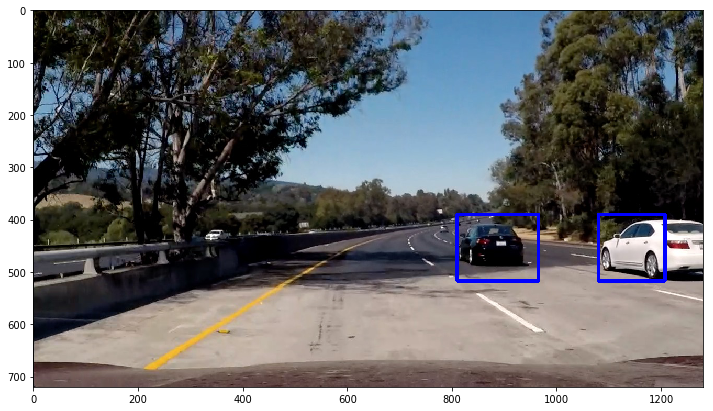

In [174]:
# test find_cars() and detect_cars() function
img = mpimg.imread('./test_images/test5.jpg')
# out_img, heatmap = pipeline(img, show_search_windows=False, heatmap_show=True)
out_img = pipeline(img)
plt.imshow(out_img)

#### Example of Heatmaps

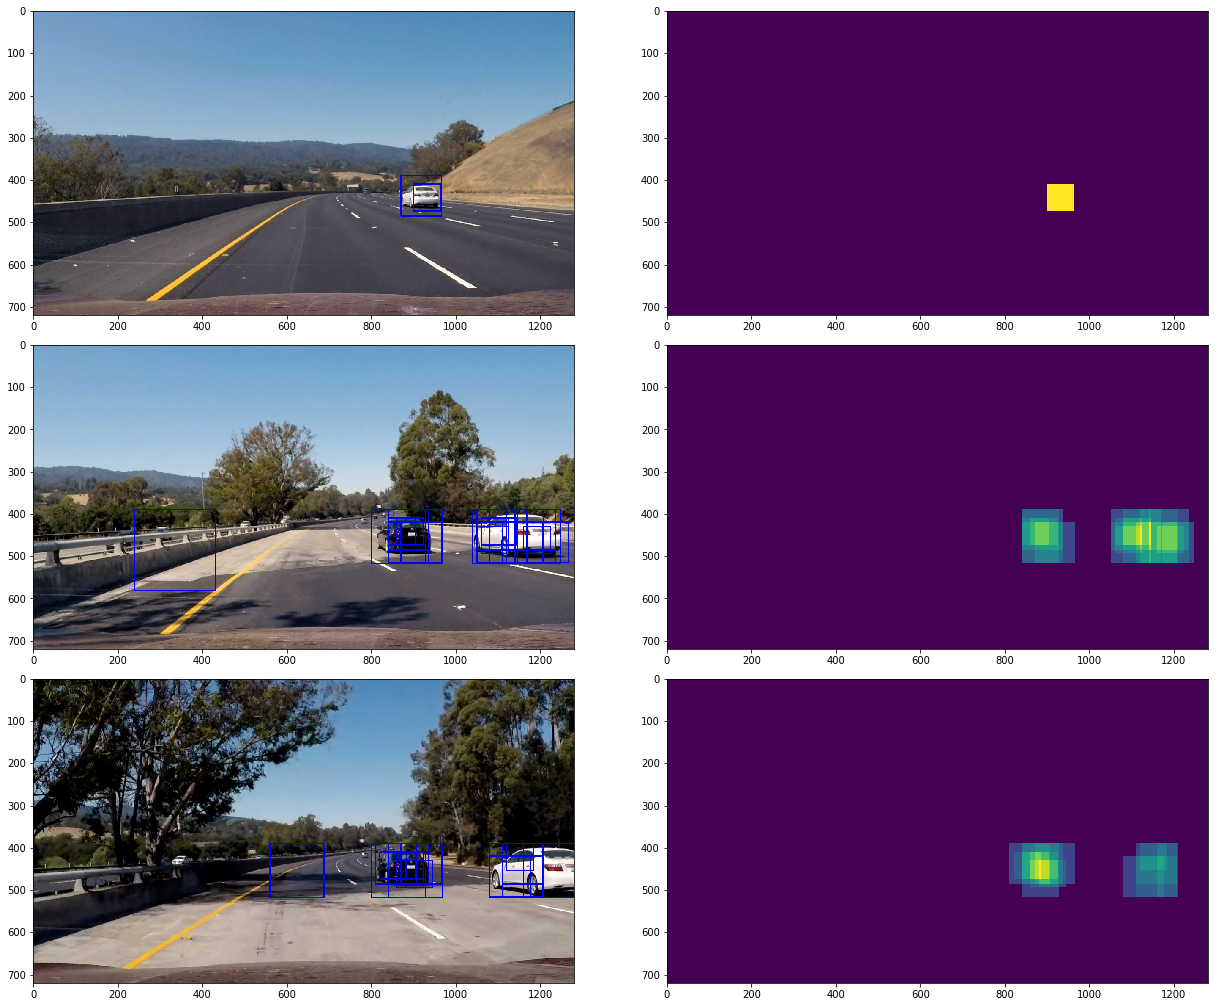

In [175]:
# Example of Heatmaps
img1 = mpimg.imread('./test_images/test3.jpg')
out_img1, heatmap1 = pipeline(img1, show_search_windows=False, heatmap_show=True)
img2 = mpimg.imread('./test_images/test4.jpg')
out_img2, heatmap2 = pipeline(img2, show_search_windows=False, heatmap_show=True)
img3 = mpimg.imread('./test_images/test5.jpg')
out_img3, heatmap3 = pipeline(img3, show_search_windows=False, heatmap_show=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 15))

ax1.imshow(out_img1)
ax2.imshow(heatmap1)
ax3.imshow(out_img2)
ax4.imshow(heatmap2)
ax5.imshow(out_img3)
ax6.imshow(heatmap3)

f.tight_layout()
plt.subplots_adjust(left=0., right=.8, top=0.9, bottom=0.)

#### Example of the pipeline output

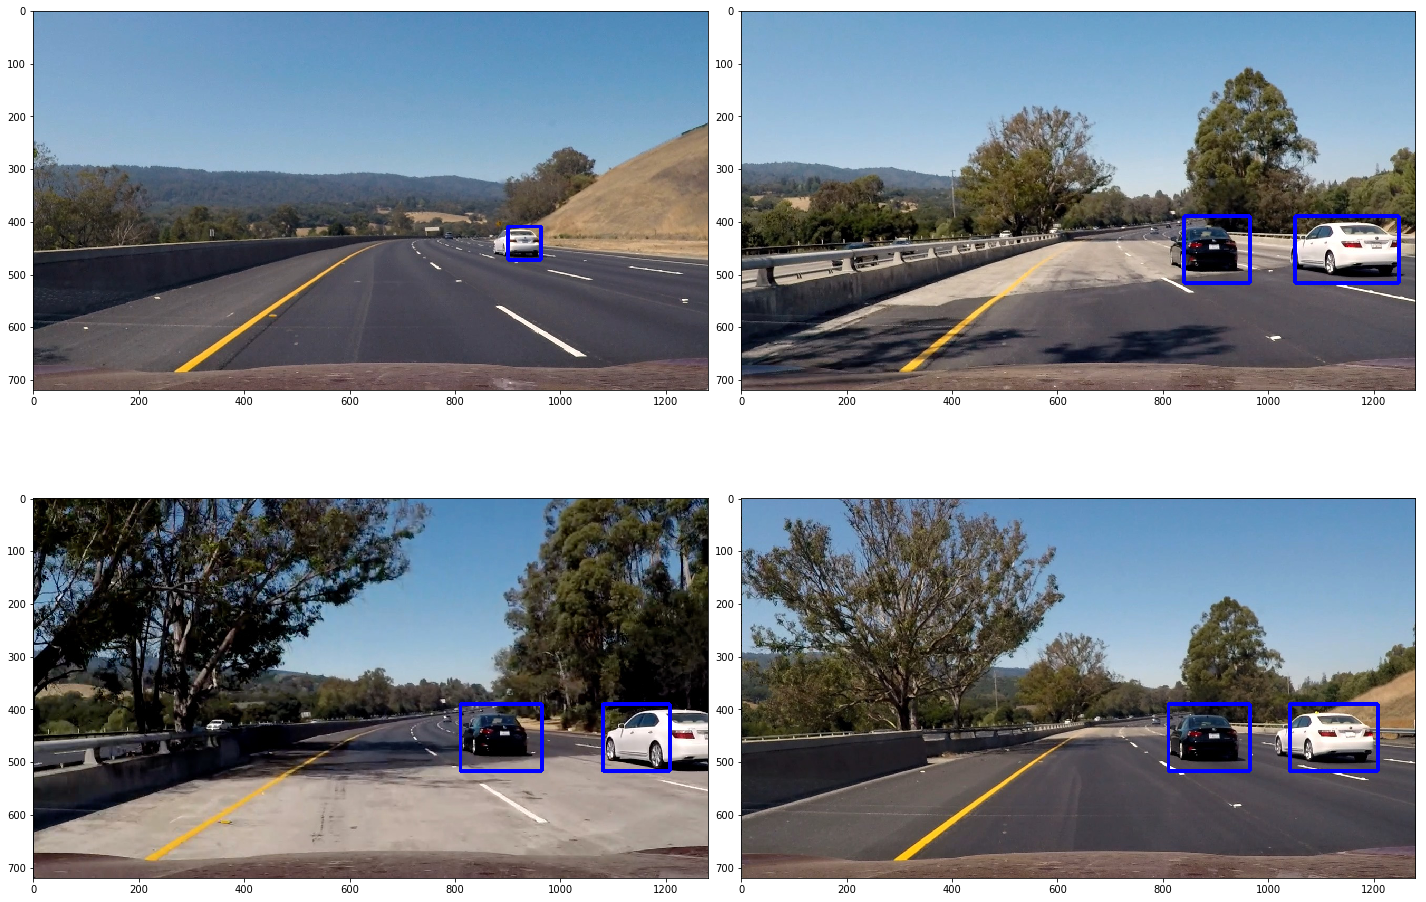

In [176]:
img1 = mpimg.imread('./test_images/test3.jpg')
out_img1 = pipeline(img1, show_search_windows=False, heatmap_show=False)
img2 = mpimg.imread('./test_images/test4.jpg')
out_img2 = pipeline(img2, show_search_windows=False, heatmap_show=False)
img3 = mpimg.imread('./test_images/test5.jpg')
out_img3 = pipeline(img3, show_search_windows=False, heatmap_show=False)
img4 = mpimg.imread('./test_images/test6.jpg')
out_img4 = pipeline(img4, show_search_windows=False, heatmap_show=False)

f, axarr = plt.subplots(2, 2, figsize=(24, 15))

axarr[0,0].imshow(out_img1)
axarr[0,1].imshow(out_img2)
axarr[1,0].imshow(out_img3)
axarr[1,1].imshow(out_img4)

f.tight_layout()
plt.subplots_adjust(left=0., right=.8, top=0.9, bottom=0.)

### Video pipeline

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set the video output and input
output = './output/project5_output.mp4'
# origin_clip = VideoFileClip('./project_video.mp4').subclip(30,45)
origin_clip = VideoFileClip('./project_video.mp4')
drawn_clip = origin_clip.fl_image(pipeline)
%time drawn_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output/project5_output.mp4
[MoviePy] Writing video ./output/project5_output.mp4



  7%|▋         | 89/1261 [02:38<34:23,  1.76s/it]